<a href="https://colab.research.google.com/github/ethanyoum/H-M-Recommendation/blob/main/Cloth_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **H&M Cloth Recommendation System Project**

In [ ]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [23:37<00:00, 23.8MB/s]
100% 28.7G/28.7G [23:37<00:00, 21.7MB/s]


In [ ]:
!unzip h-and-m-personalized-fashion-recommendations.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/089/0890677001.jpg  
  inflating: /content/images/089/0890677002.jpg  
  inflating: /content/images/089/0890677004.jpg  
  inflating: /content/images/089/0890683001.jpg  
  inflating: /content/images/089/0890683002.jpg  
  inflating: /content/images/089/0890684001.jpg  
  inflating: /content/images/089/0890684002.jpg  
  inflating: /content/images/089/0890686002.jpg  
  inflating: /content/images/089/0890697001.jpg  
  inflating: /content/images/089/0890697002.jpg  
  inflating: /content/images/089/0890700001.jpg  
  inflating: /content/images/089/0890717001.jpg  
  inflating: /content/images/089/0890717002.jpg  
  inflating: /content/images/089/0890717003.jpg  
  inflating: /content/images/089/0890722001.jpg  
  inflating: /content/images/089/0890722002.jpg  
  inflating: /content/images/089/0890734001.jpg  
  inflating: /content/images/089/0890734003.jpg  
  inflating: /content/images/089/0890741001.jpg  

In [ ]:
!ls /content/

articles.csv					  images		 transactions_train.csv
customers.csv					  sample_data
h-and-m-personalized-fashion-recommendations.zip  sample_submission.csv


In [ ]:
!rm /content/sample_submission.csv

In [ ]:
!ls /content/

articles.csv   h-and-m-personalized-fashion-recommendations.zip  sample_data
customers.csv  images						 transactions_train.csv


In [ ]:
text_path = '/content/articles.csv'
articles = pd.read_csv(text_path)
print(articles.shape)
articles.head(5)

(105542, 25)


article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

In [ ]:
text_path2 = '/content/customers.csv'
customers = pd.read_csv(text_path2)
print(customers.shape)
customers.head(5)

(1371980, 7)


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [ ]:
text_path3 = '/content/transactions_train.csv'
transactions = pd.read_csv(text_path3)
transactions = transactions.groupby('customer_id').apply(lambda x: x.sample(frac=0.7, random_state=42))
transactions = transactions.reset_index(drop=True)
print(transactions.shape)
transactions.head(5)

<ipython-input-10-bba626482bd4>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions = transactions.groupby('customer_id').apply(lambda x: x.sample(frac=0.7, random_state=42))


(22264676, 5)


t_dat                                        customer_id  article_id  \
0  2018-12-27  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   625548001   
1  2020-03-21  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   890498002   
2  2020-03-21  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   841260003   
3  2018-12-27  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   176209023   
4  2019-09-18  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   656719005   

      price  sales_channel_id  
0  0.044051                 1  
1  0.031763                 2  
2  0.011508                 2  
3  0.035576                 1  
4  0.044051                 2

In [ ]:
import os
image_dir = '/content/images'
files = os.listdir(image_dir)
print(files)

['052', '050', '077', '020', '032', '035', '022', '015', '093', '084', '059', '036', '041', '037', '065', '014', '058', '013', '025', '048', '090', '076', '054', '034', '078', '026', '087', '039', '023', '019', '029', '075', '081', '046', '055', '024', '073', '064', '060', '027', '070', '045', '012', '056', '049', '016', '079', '047', '082', '091', '062', '030', '033', '018', '061', '011', '038', '071', '031', '092', '010', '083', '086', '095', '017', '066', '044', '057', '074', '063', '068', '053', '043', '028', '089', '042', '094', '067', '072', '069', '040', '085', '051', '021', '080', '088']


['/content/images/052/0522028001.jpg', '/content/images/052/0523936038.jpg', '/content/images/052/0521062011.jpg', '/content/images/052/0523196002.jpg', '/content/images/052/0522725019.jpg', '/content/images/052/0522027002.jpg', '/content/images/052/0520496008.jpg', '/content/images/052/0522678003.jpg', '/content/images/052/0522453002.jpg', '/content/images/052/0521804006.jpg', '/content/images/052/0528931002.jpg', '/content/images/052/0525905001.jpg', '/content/images/052/0522373001.jpg', '/content/images/052/0525831014.jpg', '/content/images/052/0523936014.jpg', '/content/images/052/0526029004.jpg', '/content/images/052/0524006011.jpg', '/content/images/052/0529122001.jpg', '/content/images/052/0524529022.jpg', '/content/images/052/0526747003.jpg', '/content/images/052/0528386002.jpg', '/content/images/052/0522803001.jpg', '/content/images/052/0525838004.jpg', '/content/images/052/0525335017.jpg', '/content/images/052/0525581009.jpg', '/content/images/052/0525563014.jpg', '/content/i

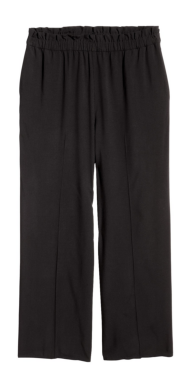

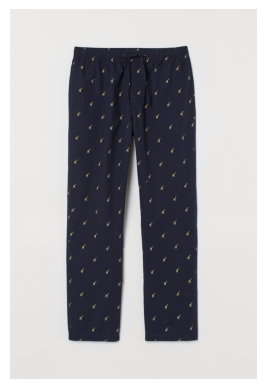

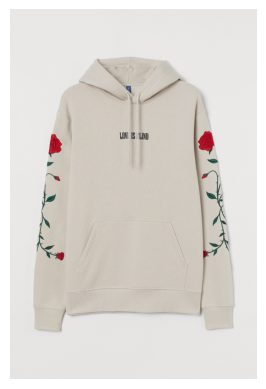

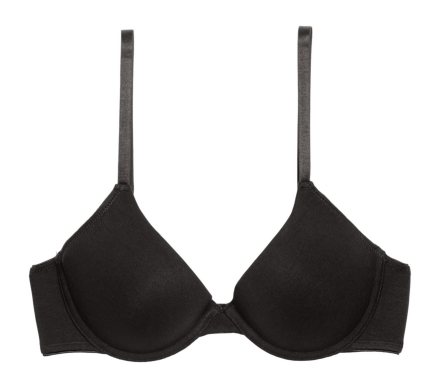

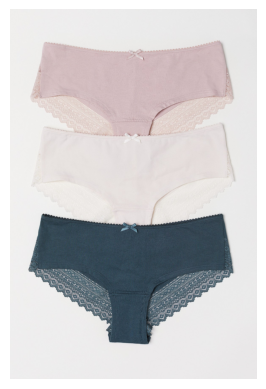

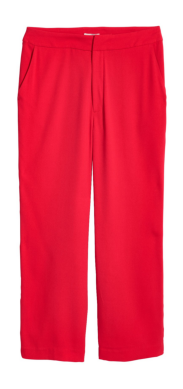

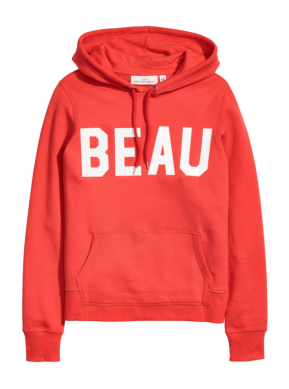

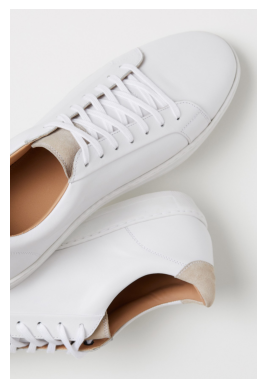

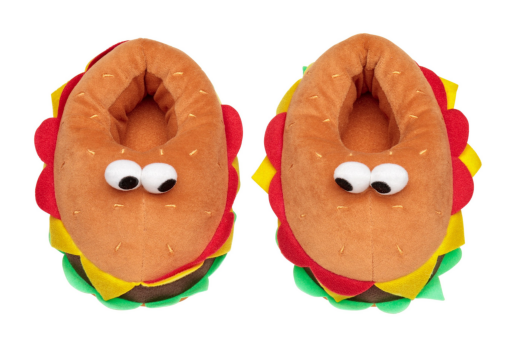

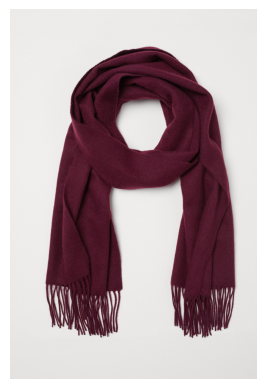

In [ ]:
# Check some products in image
import glob
from PIL import Image
image_files = glob.glob(f'{image_dir}/**/*.*', recursive = True)
print(image_files)

for img_path in image_files[0:10]:
  image = Image.open(img_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

# Data Cleaning and Pre-Processing

In [ ]:
# Missing values
missing_values_customers = customers.isnull().sum()
missing_values_articles = articles.isnull().sum()
missing_values_transactions = transactions.isnull().sum()

missing_values_summary = pd.DataFrame({
    'Dataset': (
        ['Customers'] * len(missing_values_customers) +
        ['Articles'] * len(missing_values_articles) +
        ['Transactions'] * len(missing_values_transactions)
    ),
    'Column': (
        list(missing_values_customers.index) +
        list(missing_values_articles.index) +
        list(missing_values_transactions.index)
    ),
    'Missing Values': (
        list(missing_values_customers.values) +
        list(missing_values_articles.values) +
        list(missing_values_transactions.values)
    ),
    'Missing Percentage': (
        list((missing_values_customers / len(customers) * 100).values) +
        list((missing_values_articles / len(articles) * 100).values) +
        list((missing_values_transactions / len(transactions) * 100).values)
    )
})

missing_values_summary

Dataset                        Column  Missing Values  \
0      Customers                   customer_id               0   
1      Customers                            FN          895050   
2      Customers                        Active          907576   
3      Customers            club_member_status            6062   
4      Customers        fashion_news_frequency           16011   
5      Customers                           age           15861   
6      Customers                   postal_code               0   
7       Articles                    article_id               0   
8       Articles                  product_code               0   
9       Articles                     prod_name               0   
10      Articles               product_type_no               0   
11      Articles             product_type_name               0   
12      Articles            product_group_name               0   
13      Articles       graphical_appearance_no               0   
14      Articles     graphical_appearance_name               0   
15      Articles             colour_group_code               0   
16      Articles             colour_group_name               0   
17      Articles     perceived_colour_value_id               0   
18      Articles   perceived_colour_value_name               0   
19      Articles    perceived_colour_master_id               0   
20      Articles  perceived_colour_master_name               0   
21      Articles                 department_no               0   
22      Articles               department_name               0   
23      Articles                    index_code               0   
24      Articles                    index_name               0   
25      Articles                index_group_no               0   
26      Articles              index_group_name               0   
27      Articles                    section_no               0   
28      Articles                  section_name               0   
29      Articles              garment_group_no               0   
30      Articles            garment_group_name               0   
31      Articles                   detail_desc             416   
32  Transactions                         t_dat               0   
33  Transactions                   customer_id               0   
34  Transactions                    article_id               0   
35  Transactions                         price               0   
36  Transactions              sales_channel_id               0   

    Missing Percentage  
0             0.000000  
1            65.237831  
2            66.150819  
3             0.441843  
4             1.167000  
5             1.156066  
6             0.000000  
7             0.000000  
8             0.000000  
9             0.000000  
10            0.000000  
11            0.000000  
12            0.000000  
13            0.000000  
14            0.000000  
15            0.000000  
16            0.000000  
17            0.000000  
18            0.000000  
19            0.000000  
20            0.000000  
21            0.000000  
22            0.000000  
23            0.000000  
24            0.000000  
25            0.000000  
26            0.000000  
27            0.000000  
28            0.000000  
29            0.000000  
30            0.000000  
31            0.394156  
32            0.000000  
33            0.000000  
34            0.000000  
35            0.000000  
36            0.000000

In [ ]:
# Remove FN and Active columns in the customers data
customers = customers.drop(columns = ['FN', 'Active'])
customers.head(5)

customer_id club_member_status  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...             ACTIVE   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...             ACTIVE   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...             ACTIVE   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...             ACTIVE   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...             ACTIVE   

  fashion_news_frequency   age  \
0                   NONE  49.0   
1                   NONE  25.0   
2                   NONE  24.0   
3                   NONE  54.0   
4              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [ ]:
# Remove rest of the columns except for article_id and product_code for articles dataset
columns_keep = ['article_id', 'product_code']
articles = articles[columns_keep]

In [ ]:
## Check if club_member_status and fashion_news_frequency are needed
# Aggregate transactions by customer_id
customer_purchase = transactions.groupby('customer_id').agg(total_purchases = ('article_id', 'count'),
                                                            total_spent = ('price', 'sum')).reset_index()
# Merge with customer information
customers_merged = customers.merge(customer_purchase, on = 'customer_id', how = 'left')
customers_merged.fillna({'total_purchases': 0, 'total_spent': 0}, inplace = True)

# Encode the values of each column into numerical values
customers_merged['club_member_status_num'] = customers_merged['club_member_status'].astype('category').cat.codes
customers_merged['fashion_news_frequency_num'] = customers_merged['fashion_news_frequency'].astype('category').cat.codes
#customers_merged

# Check the correlation
correlation_results = customers_merged[['club_member_status_num', 'fashion_news_frequency_num',
                                        'total_purchases', 'total_spent']].corr()
correlation_results

club_member_status_num  \
club_member_status_num                    1.000000   
fashion_news_frequency_num               -0.136772   
total_purchases                          -0.106506   
total_spent                              -0.093365   

                            fashion_news_frequency_num  total_purchases  \
club_member_status_num                       -0.136772        -0.106506   
fashion_news_frequency_num                    1.000000         0.104042   
total_purchases                               0.104042         1.000000   
total_spent                                   0.090765         0.957615   

                            total_spent  
club_member_status_num        -0.093365  
fashion_news_frequency_num     0.090765  
total_purchases                0.957615  
total_spent                    1.000000

In [ ]:
# Remove club_member_status and fashion_news_frequency as they are not good predictor
customers = customers.drop(columns = ['club_member_status', 'fashion_news_frequency', 'postal_code'])
customers

customer_id   age
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  49.0
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  25.0
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  24.0
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  54.0
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  52.0
...                                                    ...   ...
1371975  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...  24.0
1371976  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...  21.0
1371977  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...  21.0
1371978  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...  18.0
1371979  ffffd9ac14e89946416d80e791d064701994755c3ab686...  65.0

[1371980 rows x 2 columns]

In [ ]:
### Impute the NA age values in the customers dataset
## Identify customers who are not in the transaction history
whole_customers = set(customers['customer_id'])
tran_customers = set(transactions['customer_id'].unique())
no_tran_customers = whole_customers - tran_customers

## Identify customers with missing values of age
customers_na_age = set(customers[customers['age'].isna()]['customer_id'])

## Check if non-transactional customers are a subset of customers with NA age values
na_age_subset = no_tran_customers.issubset(customers_na_age)
difference_count = len(customers_na_age - no_tran_customers)
print(f"All non-transactional customers are in the missing age set: {na_age_subset}")
print(f"Number of customers with transaction history but missing age: {difference_count}")

All non-transactional customers are in the missing age set: False
Number of customers with transaction history but missing age: 15761


In [ ]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.3 MB/s eta 0:00:00


In [ ]:
import dask.dataframe as dd

# Convert Pandas to Dask DataFrames
transactions_dd = dd.read_csv('/content/transactions_train.csv', usecols=['t_dat','customer_id', 'article_id'])
def stratified_sample(group, frac=0.7, seed=42):
    np.random.seed(seed)
    return group.sample(frac=frac, random_state=seed)

transactions_dd = transactions_dd.groupby('customer_id').apply(stratified_sample, meta=transactions_dd)

In [ ]:
transactions_dd = transactions_dd.reset_index(drop=True)

In [ ]:
customers_dd = dd.read_csv('/content/customers.csv', usecols = ['customer_id', 'age'])
customers = customers_dd.compute()

articles_dd = dd.read_csv('/content/articles.csv', usecols = ['article_id', 'product_code'])
articles = articles_dd.compute()

In [ ]:
# Perform Dask Merging
transactions_merged = transactions_dd.merge(customers_dd, on='customer_id', how='left')
transactions_merged = transactions_merged.merge(articles_dd, on='article_id', how='left')

# Convert back to Pandas only if needed
transactions_merged = transactions_merged.persist()
transactions_final = transactions_merged.compute()

In [ ]:
len(transactions_final['customer_id'].unique())

1362281

In [ ]:
transactions_final.head(5)

t_dat                                        customer_id  article_id  \
0  2018-11-20  0001e7a9c3a9749ef86fd992a8a9cb487ba609b8763c7c...   625518001   
1  2019-06-13  0003e9bbb9faf3937ad3a28a5bede5c1b896c1bc6c1035...   742916002   
2  2019-06-13  0003e9bbb9faf3937ad3a28a5bede5c1b896c1bc6c1035...   559637005   
3  2019-06-13  0003e9bbb9faf3937ad3a28a5bede5c1b896c1bc6c1035...   699077006   
4  2019-06-13  0003e9bbb9faf3937ad3a28a5bede5c1b896c1bc6c1035...   699075005   

    age  product_code  
0  40.0        625518  
1  25.0        742916  
2  25.0        559637  
3  25.0        699077  
4  25.0        699075

In [ ]:
# Convert Pandas DataFrame to Dask DataFrame
transactions_final_dd = dd.from_pandas(transactions_final, npartitions=8)
customers_dd = dd.from_pandas(customers, npartitions=8)

In [ ]:
# Step 1: Separate Customers with Known and Unknown Age
customers_with_known_age_dd = transactions_final_dd[~transactions_final_dd['age'].isna()]
customers_with_unknown_age_dd = transactions_final_dd[transactions_final_dd['age'].isna()]

# Step 2: Compute Average Age for Each Product (Dask Optimized)
average_age_per_product_dd = customers_with_known_age_dd.groupby('article_id')['age'].mean().compute()

In [ ]:
# Step 3: Impute Age for Customers with Missing Values
customers_with_unknown_age_dd = customers_with_unknown_age_dd.map_partitions(
    lambda df: df.assign(imputed_age = df['article_id'].map(average_age_per_product_dd)
                         .fillna(customers['age'].median()))
)

In [ ]:
# Step 4: Compute the Dask DataFrame to Get the Imputed Ages
customers_with_unknown_age_dd = customers_with_unknown_age_dd.compute()

# Step 5: Aggregate Imputed Ages per Customer
imputed_ages_dd = customers_with_unknown_age_dd.groupby('customer_id')['imputed_age'].mean()

# Step 6: Update the Original Customers Dataset with the Imputed Ages
customers_dd = customers_dd.map_partitions(
    lambda df: df.assign(age = df['customer_id'].map(imputed_ages_dd).fillna(df['age']))
)

In [ ]:
# Step 7: Convert Back to Pandas If Needed
customers = customers_dd.compute()

# Step 8: Check for Remaining Missing Age Values
remaining_na_count = customers['age'].isna().sum()
print(f"Remaining missing age values: {remaining_na_count}")

Remaining missing age values: 100


In [ ]:
# Compute the overall median age from customers with known age
overall_median_age = customers_dd['age'].dropna().median_approximate().compute()

# Fill remaining NA values in the 'age' column
customers_dd = customers_dd.map_partitions(lambda df: df.assign(age = df['age'].fillna(overall_median_age)))

# Convert back to pandas if needed
customers = customers_dd.compute()

# Check again for any remaining missing values in age
remaining_na_count = customers['age'].isna().sum()
print(f"Remaining missing age values: {remaining_na_count}")

Remaining missing age values: 0


In [ ]:
# Recheck missing values after cleaning finished
missing_values_customers = customers.isnull().sum()
missing_values_articles = articles.isnull().sum()
missing_values_transactions = transactions.isnull().sum()

missing_values_summary = pd.DataFrame({
    'Dataset': (
        ['Customers'] * len(missing_values_customers) +
        ['Articles'] * len(missing_values_articles) +
        ['Transactions'] * len(missing_values_transactions)
    ),
    'Column': (
        list(missing_values_customers.index) +
        list(missing_values_articles.index) +
        list(missing_values_transactions.index)
    ),
    'Missing Values': (
        list(missing_values_customers.values) +
        list(missing_values_articles.values) +
        list(missing_values_transactions.values)
    ),
    'Missing Percentage': (
        list((missing_values_customers / len(customers) * 100).values) +
        list((missing_values_articles / len(articles) * 100).values) +
        list((missing_values_transactions / len(transactions) * 100).values)
    )
})

missing_values_summary

Dataset            Column  Missing Values  Missing Percentage
0     Customers       customer_id               0                 0.0
1     Customers               age               0                 0.0
2      Articles        article_id               0                 0.0
3      Articles      product_code               0                 0.0
4  Transactions             t_dat               0                 0.0
5  Transactions       customer_id               0                 0.0
6  Transactions        article_id               0                 0.0
7  Transactions             price               0                 0.0
8  Transactions  sales_channel_id               0                 0.0

In [ ]:
# Encode customer_id and article_id
customer_id_map = {cid: idx for idx, cid in enumerate(customers['customer_id'].unique())}
article_id_map = {aid: idx for idx, aid in enumerate(articles['article_id'].unique())}

transactions['customer_id'] = transactions['customer_id'].map(customer_id_map)
transactions['article_id'] = transactions['article_id'].map(article_id_map)

In [ ]:
# Temporal Train-Test Split
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
split_date = transactions['t_dat'].max() - pd.Timedelta(days = 7)

train_data = transactions[transactions['t_dat'] < split_date]
test_data = transactions[transactions['t_dat'] >= split_date]

In [ ]:
# Generate Labels
train_data['purchased'] = 1
test_data['purchased'] = 1

In [ ]:
# Convert Pandas DataFrames to Dask DataFrames
transactions_dd = dd.from_pandas(transactions, npartitions=8)
train_data_dd = dd.from_pandas(train_data, npartitions=8)

# Get unique article IDs as a Dask array for efficient random sampling
all_article_ids = transactions_dd['article_id'].unique().compute()
all_article_ids = np.array(all_article_ids)

In [ ]:
test_data.head(5)

t_dat  customer_id  article_id     price  sales_channel_id  \
86   2020-09-15            6       78503  0.061000                 2   
1748 2020-09-22          259       87371  0.042356                 2   
1790 2020-09-15          272       97666  0.050831                 2   
1923 2020-09-21          323       77256  0.042356                 2   
1945 2020-09-21          323       69711  0.033881                 2   

      purchased  
86            1  
1748          1  
1790          1  
1923          1  
1945          1

In [ ]:
len(test_data[test_data['purchased'] == 0])

0

In [ ]:
from scipy.sparse import csr_matrix

# Step 1: Precompute Customer-Item Interaction Matrix
customer_map = {cid: idx for idx, cid in enumerate(train_data['customer_id'].unique())}
article_map = {aid: idx for idx, aid in enumerate(train_data['article_id'].unique())}

train_data['customer_idx'] = train_data['customer_id'].map(customer_map)
train_data['article_idx'] = train_data['article_id'].map(article_map)

num_customers = len(customer_map)
num_articles = len(article_map)

In [ ]:
# Create a sparse matrix for fast lookup
interaction_matrix = csr_matrix(
    (np.ones(len(train_data)), (train_data['customer_idx'], train_data['article_idx'])),
    shape=(num_customers, num_articles)
)

In [ ]:
print(interaction_matrix)

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	2.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (1, 14)	2.0
  (1, 15)	2.0
  (1, 16)	1.0
  (1, 17)	1.0
  (1, 18)	1.0
  (1, 19)	2.0
  (1, 20)	2.0
  (1, 21)	1.0
  (1, 22)	2.0
  (1, 23)	1.0
  (1, 24)	1.0
  :	:
  (1355705, 7548)	1.0
  (1355705, 10091)	1.0
  (1355705, 10192)	1.0
  (1355705, 10486)	1.0
  (1355705, 11646)	1.0
  (1355705, 11770)	1.0
  (1355705, 14435)	1.0
  (1355705, 18788)	1.0
  (1355705, 20795)	1.0
  (1355705, 24291)	1.0
  (1355705, 27410)	1.0
  (1355705, 29588)	1.0
  (1355705, 30668)	1.0
  (1355705, 31053)	1.0
  (1355705, 36757)	1.0
  (1355705, 37124)	1.0
  (1355705, 44622)	1.0
  (1355705, 66648)	1.0
  (1355705, 88417)	1.0
  (1355706, 2457)	1.0
  (1355706, 8783)	1.0
  (1355706, 11140)	1.0
  (1355706, 15676)	1.0
  (1355706, 26539)	1.0
  (1355707, 25817)	1.0


In [ ]:
# Step 2: Generate Negative Samples Efficiently
def fast_negative_sampling(customer_ids, num_negatives=5):
    np.random.seed(42)
    negative_samples = []

    for customer in customer_ids:
        purchased_articles = interaction_matrix[customer].indices
        negative_articles = np.setdiff1d(np.arange(num_articles), purchased_articles, assume_unique=True)

        # Fast negative sampling
        sampled_articles = np.random.choice(negative_articles, num_negatives, replace=False)

        negative_samples.extend([[customer, article, 0] for article in sampled_articles])

    return pd.DataFrame(negative_samples, columns=['customer_idx', 'article_idx', 'purchased'])

In [ ]:
# Step 3: Process in Parallel
customer_batches = np.array_split(np.arange(num_customers), 16)  # Increase batch size for faster processing
negative_samples_list = [fast_negative_sampling(batch) for batch in customer_batches]

In [ ]:
# Merge Negative Samples
negative_samples = pd.concat(negative_samples_list)

# Prepare the Dataset

In [ ]:
class RecommendationDataset(Dataset):
    def __init__(self, df):
        self.customers = torch.tensor(df['customer_id'].values, dtype=torch.long)
        self.articles = torch.tensor(df['article_id'].values, dtype=torch.long)
        self.labels = torch.tensor(df['purchased'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.customers)

    def __getitem__(self, idx):
        return self.customers[idx], self.articles[idx], self.labels[idx]


In [ ]:
# Create Dataset and DataLoader
train_dataset = RecommendationDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Create Train and Validation dataset
train_dataset = RecommendationDataset(train_data['customer_id'].values, train_data['article_id'].values,
                                      train_data['purchased'].values)
val_dataset = RecommendationDataset(test_data['customer_id'].values, test_data['article_id'].values,
                                    test_data['purchased'].values)

# Create Trainloader and Validation-loader
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

TypeError: RecommendationDataset.__init__() takes 2 positional arguments but 4 were given

# Define Model

In [ ]:
class RecommendationModel(nn.Module):
    def __init__(self, num_customers, num_articles, embedding_dim=128):
        super(RecommendationModel, self).__init__()
        self.customer_embedding = nn.Embedding(num_customers, embedding_dim)
        self.article_embedding = nn.Embedding(num_articles, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(self, customer_id, article_id):
        customer_emb = self.customer_embedding(customer_id)
        article_emb = self.article_embedding(article_id)
        concat = torch.cat([customer_emb, article_emb], dim=1)
        output = self.fc(concat)
        return torch.sigmoid(output)

In [ ]:
class RecommendationModel(nn.Module):
  def __init__(self, num_customers, num_articles, embedding_dim = 128):
    super(RecommendationModel, self).__init__()
    self.customer_embedding = nn.Embedding(num_customers, embedding_dim)
    self.article_embedding = nn.Embedding(num_articles, embedding_dim)
    self.fc_layers = nn.Sequential(
        nn.Linear(embedding_dim * 2, 1),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

  def forward(self, customer_id, article_id):
    customer_embedding = self.customer_embedding(customer_id)
    article_embedding = self.article_embedding(article_id)
    combined = torch.cat([customer_embedding, article_embedding], dim = 1)
    return self.fc_layers(combined)

In [ ]:
# Define parameters
embedding_dim = 128
model = RecommendationModel(num_customers, num_articles, embedding_dim)

In [ ]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0
  for customer_id, article_id, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(customer_id, article_id).squeeze()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f'Epoch ', epoch + 1, 'Train Loss:', train_loss/len(train_loader))

In [ ]:
# Validate the model
for epoch in range(num_epochs):
  model.eval()
  validation_loss = 0.0
  with torch.no_grad():
    for customer_id, article_id, labels in val_loader:
      outputs = model(customer_id, article_id).squeeze()
      loss = criterion(outputs, labels)
      validation_loss += loss.item()
  print(f'Epoch ', epoch + 1, 'Validation Loss', validation_loss/len(val_loader))
